# Call Home Assistant API
More info https://developers.home-assistant.io/docs/api/rest/

In [1]:
import requests
import json

api_base_url = "http://homeassistant.local:8123"
api_token = "***"

def call_api(path, body = None):
    url = f"{api_base_url}{path}"
    headers = {
        "Authorization": f"Bearer {api_token}",
        "content-type": "application/json",
    }

    if not body:
        response = requests.get(url, headers=headers)
    else:
        response = requests.post(url, body, headers=headers)
    try:
        return response.json()
    except:
        print(response.text)
        
call_api("/api/")

401: Unauthorized


# Load temperature sensor data from Home Assistant

In [2]:
def get_data_from_home_assistant():
    sensor_entity_ids = [
        "sensor.living_room_temperature_temperature", 
        "sensor.outdoor_temperature_temperature",
        "sensor.stairs_motion_sensor_temperature",
        "sensor.office_temperature_temperature",
    ]
    temperature_data = []
    for sensor_entity_id in sensor_entity_ids:
        history_response = call_api(f"/api/history/period?filter_entity_id={sensor_entity_id}")
        temperature_data += history_response[0]
        
    return temperature_data


#temperature_data = get_data_from_home_assistant()
#temperature_data[0]

# Convert JSON data into pandas dataframe

In [3]:
import pandas as pd

def get_temperature_dataframe():
    df = pd.DataFrame(temperature_data)
    df = pd.concat([df, pd.json_normalize(df.attributes)], axis=1)
    df = df[(df.temperature != "unknown") & (df.temperature != "unavailable")]
    df["temperature"] = df.temperature.astype(float)
    df["measurement_datetime"] = pd.to_datetime(df["last_changed"])

    df["measurement_datetime_local"] = df.measurement_datetime.dt.tz_convert(tz="Australia/Sydney")

    return  df[["entity_id", "temperature", "measurement_datetime_local"]]

def load_from_csv():
    df_temperature = pd.read_csv("https://raw.githubusercontent.com/maxim75/data-visualization/master/notebooks/data/temperature_history.csv")
    df_temperature["temperature"] = df_temperature.temperature.astype(float)
    df_temperature["measurement_datetime_local"] = pd.to_datetime(df_temperature.measurement_datetime_local)
    return df_temperature

# uncomment to get data from home assistant
#df_temperature = get_temperature_dataframe()

# use sample data from CSV file
df_temperature = load_from_csv()

df_temperature

,entity_id,temperature,measurement_datetime_local
0,sensor.living_room_temperature_temperature,27.71,2022-01-16 21:42:06.367993+11:00
1,sensor.living_room_temperature_temperature,27.67,2022-01-16 21:49:18.604760+11:00
2,sensor.living_room_temperature_temperature,27.65,2022-01-16 22:09:02.214643+11:00
3,sensor.living_room_temperature_temperature,27.57,2022-01-16 22:17:53.908034+11:00
4,sensor.living_room_temperature_temperature,27.46,2022-01-16 22:38:28.171008+11:00
...,...,...,...
320,sensor.office_temperature_temperature,28.96,2022-01-17 20:27:11.974092+11:00
321,sensor.office_temperature_temperature,28.95,2022-01-17 20:35:33.551919+11:00
322,sensor.office_temperature_temperature,28.75,2022-01-17 21:08:19.654579+11:00
323,sensor.office_temperature_temperature,28.54,2022-01-17 21:30:33.573953+11:00


# Render temperature chart

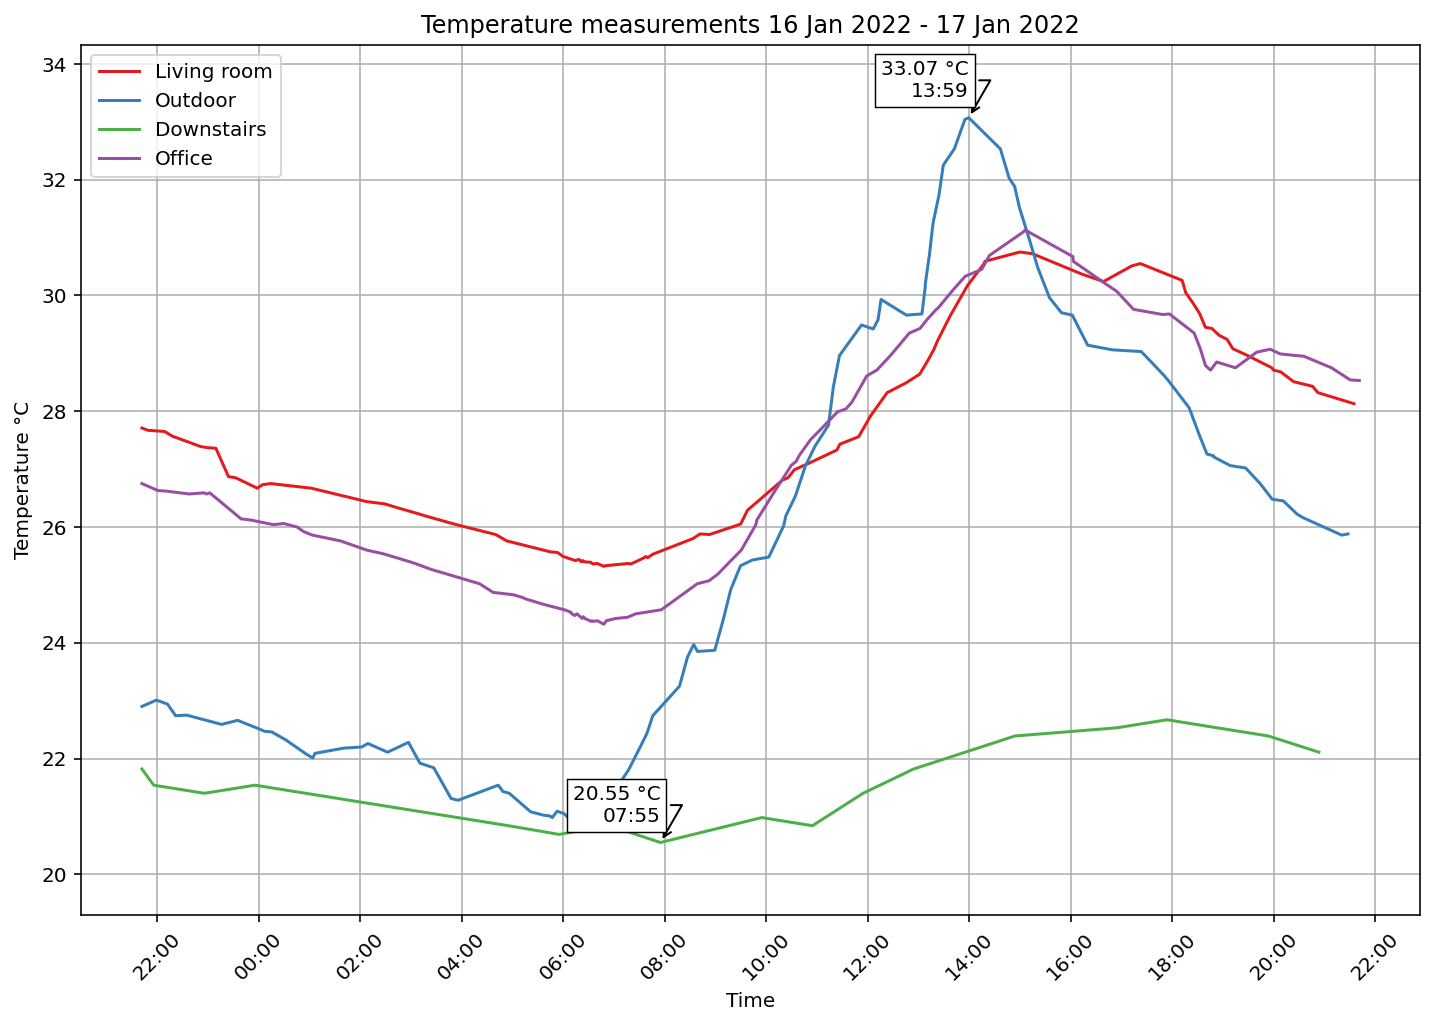

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib
import seaborn as sns
import pytz
import datetime

# use high DPI resolution for retina screens like MacBook
%config InlineBackend.figure_format = 'retina'

# define chart size
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

# get a list of temperature sensors
entity_ids = df_temperature.entity_id.unique()

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='Set1')

label_map = {
    "sensor.living_room_temperature_temperature": "Living room",
    "sensor.outdoor_temperature_temperature": "Outdoor",
    "sensor.office_temperature_temperature": "Office",
    "sensor.stairs_motion_sensor_temperature": "Downstairs",
}

idx = 0
for entity_id in df_temperature.entity_id.unique():
    ax.plot("measurement_datetime_local", "temperature", data=df_temperature[df_temperature.entity_id == entity_id].reset_index(), c=scalarMap.to_rgba(idx), label=label_map[entity_id])
    idx += 1

date_form = mdates.DateFormatter("%H:%M", tz=pytz.timezone('Australia/Sydney')) 

ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2)) 

ax.xaxis.set_major_formatter(date_form)
ax.tick_params('x', labelrotation=45)

ax.legend(loc="upper left")
ax.set_title(f"Temperature measurements {df_temperature.measurement_datetime_local.min():%d %b %Y} - {df_temperature.measurement_datetime_local.max():%d %b %Y}")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature °C")

min_temperature_row = df_temperature[df_temperature.index == df_temperature.temperature.idxmin()]
max_temperature_row = df_temperature[df_temperature.index == df_temperature.temperature.idxmax()]


# add bit of space above and below min and max temperature for annotaion note
temp_range = df_temperature.temperature.max() - df_temperature.temperature.min()
ax.set_ylim(df_temperature.temperature.min()-+temp_range/10, df_temperature.temperature.max()+temp_range/10)

def show_annotation(row):
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    
    position = (row.measurement_datetime_local, row.temperature)

    ax.annotate(f"{row.temperature.values[0]} °C\n{row.measurement_datetime_local.dt.strftime('%H:%M').values[0]}", xy=position, xytext=(position[0], position[1]+1),
                  bbox=bbox_props, ha="right", va="top", arrowprops=arrowprops)
    

show_annotation(min_temperature_row)
show_annotation(max_temperature_row)

# show grid for axis ticks
ax.grid()